In [1]:
#"""
!pip install nptyping
!pip install ml_metrics
!pip install hyperopt
#"""

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=ab549a216d69e7f07b7e241ae924c2aafb7ad5a43ae23e7dcf0e6aec847d7621
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, vstack, save_npz, load_npz
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ml_metrics 
from typing import Dict, Any
from nptyping import NDArray
from sklearn.cluster import AffinityPropagation, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import davies_bouldin_score

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt import hp
from matplotlib import pyplot as plt

DATA_DIR = './drive/My Drive/Colab Notebooks/VK_internship/'
sys.path.append(DATA_DIR)
recommendation = __import__("recommendation") 

In [0]:
class HPOpt(object):
    """
    Tree Of Parzen Estimators для оптимизации Affinity Propagation.
    В качестве функции оптимизации была взята метрика davies_bouldin_score
    """
    def __init__(self, dtrain, estimator):
        self.dtrain = dtrain
        self.estimator = estimator

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, 
                      algo=algo, max_evals=max_evals, 
                      trials=trials)
        return result, trials

    def bayes_opt_tune_Affinity(self, params_dict):
        estimator = self.estimator.set_params(**params_dict)
        # К сожалению, метод AffinityPropagation из библиотеки не работает 
        # со sparse матрицами, хоть в документации и утверждается обратное
        estimator = estimator.fit(self.dtrain.toarray())
        # функция davies_bouldin_score выдает ошибки в крайних случаях:
        # когда кластер один и когда количество кластеров соответствует числу элементов
        try: 
            score = davies_bouldin_score(self.dtrain.toarray(), estimator.labels_)
        except:
            score = 1000
        print("params:", params_dict, " score: ", score)
        return {'loss': score, 'status': STATUS_OK}


In [0]:
train_matrix = load_npz(DATA_DIR+"train_matrix.npz")
test_matrix = load_npz(DATA_DIR+"test_matrix.npz")
user_artists_df = pd.read_csv(DATA_DIR+"users_artists.csv", usecols=["user_id", "artists"]).drop_duplicates()

artists_id = user_artists_df["artists"].unique()
artists_id.sort()
train, test = train_test_split(artists_id, test_size=0.1)
del artists_id

partial_user_artists_df = user_artists_df.loc[user_artists_df["artists"].isin(train)]
del train
partial_artists = partial_user_artists_df.groupby("artists").count().reset_index()
del partial_user_artists_df
partial_artists = partial_artists.sort_values(by="user_id", ascending = False)
partial_artists_rows = partial_artists.loc[:,"artists"].values
del partial_artists

In [5]:
print(train_matrix.shape)

(460500, 1000)


К сожалению, affinity propagation не работает с большими объемами данных.
В документации sklearn указано, что входное множество может быть sparse-матрицей, что не соответствует действительности.
Поэтому пришлось барть лишь часть данных, так как обучения по батчам алгоритм также не поддерживает.

In [0]:
# Из матрицы убираются нулевые строки, для обучения берется половина непустых строк:
non_zero_rows_idxs = np.unique(train_matrix.nonzero()[0])
train_idxs = np.random.choice(non_zero_rows_idxs, size=int(round(len(non_zero_rows_idxs)/30))) # больше не помещается в памяти
train_matrix = train_matrix[train_idxs, :]

In [7]:
print(train_matrix.shape)

(13092, 1000)


В результате, чтобы не было переполнения памяти, алгоритм включает лишь 1/30 часть данных, что является крайне малым.

Affinity Propagation:

Оптимизация гиперпараметров алгоритма:

In [8]:
optimizer = HPOpt(train_matrix, AffinityPropagation(copy=False))

search_space_affinity = {
    "preference": hp.choice("preference", range(-25,5)), # self-similarity
    "damping": hp.uniform("damping", 0.5, 1.0)
}

trials=Trials()

optimization_proc_affinity = optimizer.process(fn_name='bayes_opt_tune_Affinity', 
                                      space=search_space_affinity, 
                                      trials=trials, 
                                      algo=tpe.suggest, 
                                      max_evals=25)
# 25 = 5^2, где 2 - количество параметров для оптимизации

params:
{'damping': 0.9366107668034442, 'preference': 1}
 score: 
1000
params:
{'damping': 0.6328747851262722, 'preference': -5}
 score: 
1000
  8%|▊         | 2/25 [12:40<1:38:05, 255.91s/it, best loss: 1000.0]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.9761888489444221, 'preference': -14}
 score: 
0.7588292789850105
params:
{'damping': 0.7225230889068375, 'preference': -19}
 score: 
1000
 16%|█▌        | 4/25 [25:44<2:03:43, 353.48s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.8988369478063556, 'preference': -10}
 score: 
1000
 20%|██        | 5/25 [37:14<2:31:30, 454.55s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.8760581408027664, 'preference': -16}
 score: 
1000
 24%|██▍       | 6/25 [48:52<2:47:04, 527.58s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.5685548489687648, 'preference': 3}
 score: 
1000
params:
{'damping': 0.6824622100520175, 'preference': -4}
 score: 
1000
 32%|███▏      | 8/25 [1:01:30<2:15:58, 479.91s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.8262744511109883, 'preference': -9}
 score: 
1000
 36%|███▌      | 9/25 [1:13:05<2:25:08, 544.26s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.9703284476567895, 'preference': 4}
 score: 
1000
params:
{'damping': 0.6925208888710979, 'preference': -21}
 score: 
1000
 44%|████▍     | 11/25 [1:25:59<1:54:59, 492.83s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.7569515693586828, 'preference': -4}
 score: 
1000
 48%|████▊     | 12/25 [1:37:29<1:59:38, 552.21s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.7993447078443026, 'preference': -4}
 score: 
1000
params:
{'damping': 0.8634853807319638, 'preference': -17}
 score: 
1000
 56%|█████▌    | 14/25 [2:00:40<1:54:40, 625.48s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.6847452378341059, 'preference': -5}
 score: 
1000
 60%|██████    | 15/25 [2:12:16<1:47:46, 646.70s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.8220690313950985, 'preference': -6}
 score: 
1000
 64%|██████▍   | 16/25 [2:23:52<1:39:12, 661.40s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.7231801716801878, 'preference': -8}
 score: 
1000
 68%|██████▊   | 17/25 [2:35:28<1:29:35, 671.91s/it, best loss: 0.7588292789850105]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.9705155046817122, 'preference': -23}
 score: 
0.7479949326662326
params:
{'damping': 0.7961866127987102, 'preference': -11}
 score: 
1000
 76%|███████▌  | 19/25 [2:48:30<55:35, 555.99s/it, best loss: 0.7479949326662326]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.7305259009642139, 'preference': 3}
 score: 
1000
params:
{'damping': 0.9968170633159221, 'preference': -23}
 score: 
0.7479949326662326
params:
{'damping': 0.9885666126709385, 'preference': -23}
 score: 
0.7479949326662326
params:
{'damping': 0.9109935346571675, 'preference': -23}
 score: 
1000
 92%|█████████▏| 23/25 [3:04:12<12:42, 381.44s/it, best loss: 0.7479949326662326]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)



params:
{'damping': 0.99921580494066, 'preference': -22}
 score: 
0.7512632066639382
params:
{'damping': 0.9970098754421272, 'preference': 2}
 score: 
1000
100%|██████████| 25/25 [3:06:48<00:00, 448.32s/it, best loss: 0.7479949326662326]


Судя по оптимизации, адекватная оценка качсевта достигается при 'damping': 0.9705155046817122 и 'preference': -23.
Теперь надо определить количество итераций, которые необходимо произвести при обучении.

max_iter: 100  score:  0.7479949326662326
max_iter: 300  score:  0.7479949326662326
max_iter: 500  score:  0.7479949326662326
max_iter: 700  score:  0.7479949326662326
max_iter: 900  score:  0.7479949326662326


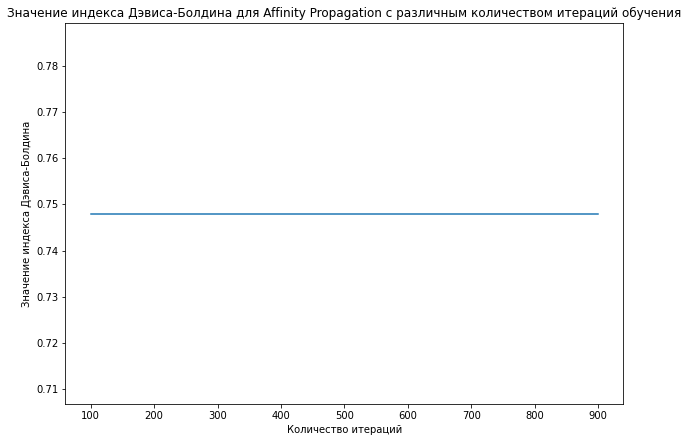

In [14]:
scores = np.array([])
x = [100,300,500,700,900]
for max_iter in x:
  optimized_affinity = AffinityPropagation(max_iter=max_iter, copy=False)
  optimized_affinity = optimized_affinity.set_params(**{'damping': 0.9705155046817122, 'preference': -23})
  optimized_affinity = optimized_affinity.fit(train_matrix.toarray())
  try: 
      score = davies_bouldin_score(train_matrix.toarray(), optimized_affinity.labels_)
  except:
      score = 1000
  scores = np.append(scores,score)
  print("max_iter:", max_iter, " score: ", score)

plt.figure(figsize=(10,7))
plt.plot(x, scores)

plt.title("Значение индекса Дэвиса-Болдина для Affinity Propagation с различным количеством итераций обучения")
plt.ylabel("Значение индекса Дэвиса-Болдина")
plt.xlabel("Количество итераций")
plt.show()

Судя по значениям метрики при разном количестве итераций, можно сказать, что модель обучается не более чем за 100 итераций.

In [0]:
#iter_num = x[np.argmin(scores)]
optimized_affinity = AffinityPropagation(max_iter=100, copy=False)
optimized_affinity = optimized_affinity.set_params(**{'damping': 0.9705155046817122, 'preference': -23})

Теперь подсчет метрик качества оптимизации:

In [17]:
metrics = recommendation.get_cluster_recommendations_and_calculate_metrics(
    optimized_affinity, 
    user_artists_df, 
    train_matrix, 
    test_matrix, 
    partial_artists_rows[train_idxs], # идентификаторы исполнителей, которые присутствуют в тренировочной части
    test
)

Основные статистики кластеризации:
Количество исполнителей:  13092
Количество кластеров: 6543
Наибольший размер кластера: 225
Гистограмма распределения количества кластеров по их величине
Деления: 
 [   1    2    3    4    5   10   50  100  500 1000]
Частоты: 
 [5680  211  197  118  191  127    8   11    0]
MAP@1:  0.003028704300760107
MAP@5:  0.0006995329933368502
MAP@10:  0.000408386579908944
MAP@20:  0.0002628133731949907


Судя по статистикам, алгоритм крайне плохо выделяет кластеры: больше трети исплнителей образовали индивидуальные кластеры, что очень сильно влияет на метрику качества.
Метрики качества рекомендации крайне плохи по сравнению с baseline, что говорит о несостоятельности применяемого метода.